In [1]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.stats import pearsonr
import mavenn
import pdb
%matplotlib notebook

In [2]:
def my_rsquared(x,y, bootstrap_samples=100):
    """Returns R^2 and SE thereof based on bootstrap resampling"""
    r2 = pearsonr(x,y)[0]**2 
    N = len(x)
    assert len(x)==len(y), f'len(x)={len(x)} and len(y)={len(y)} are not the same.'
    r2s = np.zeros(bootstrap_samples)
    for i in range(bootstrap_samples):
        ix = np.random.choice(a=bootstrap_samples, size=bootstrap_samples, replace=True)
        r2s[i] = pearsonr(x[ix],y[ix])[0]**2 
    dr2 = np.std(r2s)
    return r2, dr2

In [3]:
style_file_name = 'figS3.style'
s = """
axes.linewidth:     0.5     # edge linewidth
font.size:          7.0
axes.labelsize:     7.0  # fontsize of the x any y labels
xtick.labelsize:    7.0  # fontsize of the tick labels
ytick.labelsize:    7.0  # fontsize of the tick labels
legend.fontsize:      7.0
legend.borderpad:     0.2  # border whitespace
legend.labelspacing:  0.2  # the vertical space between the legend entries
legend.borderaxespad: 0.2  # the border between the axes and legend edge
legend.framealpha:    1.0 
"""
with open(style_file_name, 'w') as f:
    f.write(s)
    
plt.style.use(style_file_name)
plt.rc('font', family='sans-serif')
plt.rc('font', family='sans-serif')

In [4]:
def draw(model_file,
         dataset_file,
         ax,
         scatter_alpha,
         yticks,
         ylim):
    '''Draws Fig. S3 panels'''

    # Load model
    print(f'Loading model from {model_file} ...')
    model = mavenn.load(model_file)
    
    # Load dataset
    print(f'Loading dataset from {dataset_file} ...')
    data_df = pd.read_csv(dataset_file)
    
    # Get indices for aa order used in Seuma et al. and Bolognesi et al.
    alphabet = np.array(list('GAVLMIFYWKRDESTCNQHP*'))
    aix = alphabet[:-1].argsort()
    sorted_aa = alphabet[aix]
    aixx = aix.argsort()
    sorted_aa[aixx]
    aixx = np.append(aixx,int(20))
    aixx
    
    # Get a bunch of parameters
    theta_lc = model.get_theta()['theta_lc'][:,aixx]
    alphabet = model.alphabet[aixx]
    
    # Compute phi grid stuff
    #phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)
    #yhat_grid = model.phi_to_yhat(phi_grid)
    yhat_grid = np.linspace(ylim[0], ylim[1])
    yqs_grid = model.yhat_to_yq(yhat_grid, q=[0.025, 0.975])  
    
    # Compute wt seq stuff
    wt_seq = model.x_stats['consensus_seq']
    phi_wt = model.x_to_phi(wt_seq)
    yhat_wt = model.phi_to_yhat(phi_wt)
    
    # Compute test data stuff
    test_ix = (data_df['set']=='test')
    x_test = data_df['x'][test_ix].values
    phi_test = model.x_to_phi(x_test)
    yhat_test = model.phi_to_yhat(phi_test)
    y_test = data_df['y'][test_ix].values
    
    # Compute metrics
    r2, dr2 = my_rsquared(yhat_test, y_test) 
    I_var, dI_var = model.I_variational(x_test, y_test)
    I_pred, dI_pred = model.I_predictive(x_test, y_test)

    # Plot y vs yhat for test data
    ax.scatter(yhat_test,
               y_test, 
               s=2,
               alpha=scatter_alpha,
               color='C0',
               label='test data')
    ax.set_xticks(yticks)
    ax.set_yticks(yticks)
    ax.set_xlabel('model prediction ($\hat{y}$)')
    ax.set_ylabel('nucleation score ($y$)')
    ax.plot(ylim, ylim, linestyle='-', color='C1', linewidth=2, label='$y = \hat{y}$')
    ax.plot(yhat_grid, yqs_grid[:,0], linestyle=':', color='C1', linewidth=1, label='95% CI')
    ax.plot(yhat_grid, yqs_grid[:,1], linestyle=':', color='C1', linewidth=1)

    # Indicate yhat for wt sequence
    ax.set_xlim(ylim)
    ax.set_ylim(ylim)
    ax.axvline(yhat_wt, color='lightgray', zorder=-1, label='WT $\hat{y}$')
    
    # Display r^2
    yint = ylim[1]-ylim[0]
    ax.text(x=ylim[0]+.02*yint, 
            y=ylim[1]-.05*yint,
        s=f'$R^2 =$ {r2:.3f} $\pm$ {dr2:.3f}', 
        ha='left', va='center');
    
    # Display legend
    leg = ax.legend(loc='lower right')
    for lh in leg.legendHandles:
        lh.set_alpha(1)

<IPython.core.display.Javascript object>


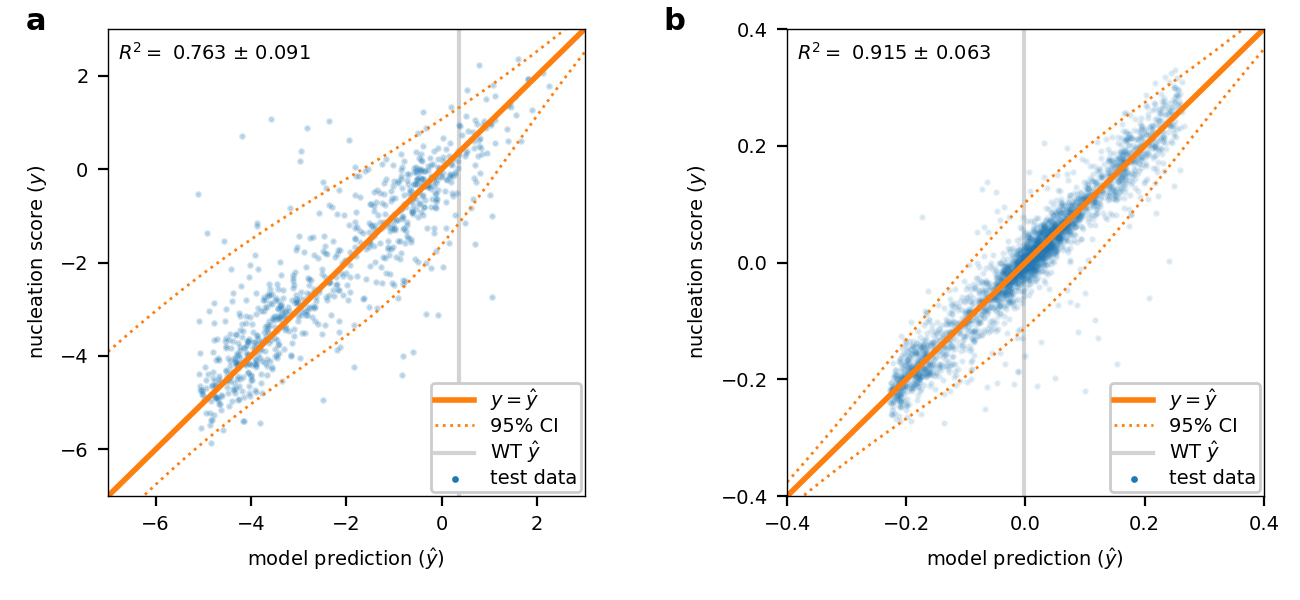

Computing and drawing results for amyloid beta...
Loading model from ../models/amyloid_additive_ge_2021.12.28.12h.47m ...
Model loaded from these files:
	../models/amyloid_additive_ge_2021.12.28.12h.47m.pickle
	../models/amyloid_additive_ge_2021.12.28.12h.47m.h5
Loading dataset from ../datasets/amyloid_data.csv.gz ...
Computing and drawing results for TDP-43
Loading model from ../models/tdp43_additive_ge_2021.12.28.12h.49m ...
Model loaded from these files:
	../models/tdp43_additive_ge_2021.12.28.12h.49m.pickle
	../models/tdp43_additive_ge_2021.12.28.12h.49m.h5
Loading dataset from ../datasets/tdp43_data.csv.gz ...


In [5]:
fig = plt.figure(figsize=[6.5, 3])

plt.style.use(style_file_name)
gs = fig.add_gridspec(1, 2)

# Define panels
ax_a = fig.add_subplot(gs[0, 0])
ax_b = fig.add_subplot(gs[0, 1])

# Draw results for amyloid beta
print('Computing and drawing results for amyloid beta...')
draw(model_file='../models/amyloid_additive_ge_2021.12.28.12h.47m',
     dataset_file='../datasets/amyloid_data.csv.gz',
     ax=ax_a,
     scatter_alpha=.2,
     yticks = [-6,-4,-2,0,2],
     ylim = [-7, 3]
)

# Draw results for TDP-43
print('Computing and drawing results for TDP-43')
draw(model_file='../models/tdp43_additive_ge_2021.12.28.12h.49m',
     dataset_file='../datasets/tdp43_data.csv.gz',
     ax=ax_b,
     scatter_alpha=.1,
     yticks = [-0.4,-0.2,0.0,0.2,0.4],
     ylim = [-0.4, 0.4]
)

# Add panel labels
fig.text(0.02, 0.95, 'a', fontsize=11, fontweight='bold')
fig.text(0.51, 0.95, 'b', fontsize=11, fontweight='bold')

# Clean up and save
fig.tight_layout(w_pad=5)
fig.savefig('png/figS3_ipynb.png', dpi=400, facecolor='w')